## Starting with Left/Right work

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# from IPython.display import Image
!pip install -q python-telegram-bot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# path to set 2 dataset
data = "/content/drive/MyDrive/speedata/set2.zip"

In [7]:
# copy the dataset to the Runtime
!mkdir /content/set2
!unzip -qq $data -d /content/set2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, telegram, json, cv2, shutil, time, random
from PIL import Image

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")
BATCH =  16#@param {type:"integer"}

cuda activated.


In [3]:
class send(): 

  def __init__(self):
    f = open ('/content/drive/MyDrive/tel.json', 'r')
    self.tel = json.load(f)
    f.close()
    self.bot = telegram.Bot(token=self.tel['token']) 

  def msg(self, mesg):
    self.bot.sendMessage(chat_id=self.tel['nnboiid'], text=mesg)

  def pic(self, path):
    self.bot.sendPhoto(chat_id=self.tel['nnboiid'], photo=open(path, 'rb'))
bot = send()

## Preprocess the data

### Image augmentation for the NN to generalise better

### Train-Test split

In [10]:
# IGNORE
# paths = {
#     'a': [],
#     'd': []
# }

In [11]:
# IGNORE
# paths['a'] += os.listdir('/content/set2/a')
# paths['d'] += os.listdir('/content/set2/d')

In [12]:
# IGNORE
# paths['a'] = ['set2/a/'+i for i in paths['a']]
# paths['d'] = ['set2/d/'+i for i in paths['d']]

In [32]:
!cp -r /content/set2/ /content/drive/MyDrive/speedata/set2/

In [4]:
SPLIT_FOLDERS = {
    'TRAIN': os.path.join("set2","train"),
    'TRAIN_a': os.path.join("set2","train","a"),
    'TRAIN_d': os.path.join("set2","train","d"),
    'TEST': os.path.join("set2","test"),
    'TEST_a': os.path.join("set2","test","a"),
    'TEST_d': os.path.join("set2","test","d")
}

In [5]:
for key in SPLIT_FOLDERS:
  if not os.path.isdir(SPLIT_FOLDERS[key]):
    os.mkdir(SPLIT_FOLDERS[key])
    print(f"{SPLIT_FOLDERS[key]} created")

### Split the data and save the image names in a json file

In [6]:
# IGNORE
# from math import floor
# splitted_data_paths = {
#     'train_a': paths['a'][:floor(len(paths['a'])*0.8)],
#     'train_d': paths['d'][:floor(len(paths['d'])*0.8)],
#     'test_a': paths['a'][floor(len(paths['a'])*0.8):],
#     'test_d': paths['d'][floor(len(paths['d'])*0.8):]
# }

In [7]:
f = open ('/content/drive/MyDrive/speedata/data.json', 'r')
load_data = json.load(f)
f.close()

### Moving the images to the appropriate directories

In [9]:
try:
  print("Creating train split for 'a' class")
  for path in load_data['train_a']:
    shutil.move(path, SPLIT_FOLDERS['TRAIN_a'])
except:
  pass
try:  
  print("Creating train split for 'd' class")
  for path in load_data['train_d']:
    shutil.move(path, SPLIT_FOLDERS['TRAIN_d'])
except:
  pass
try:
  print("Creating test split for 'a' class")
  for path in load_data['test_a']:
    shutil.move(path, SPLIT_FOLDERS['TEST_a'])
except:
  pass
try:
  print("Creating test split for 'd' class")
  for path in load_data['test_d']:
    shutil.move(path, SPLIT_FOLDERS['TEST_d'])
except:
  pass
try:
  os.rmdir('set2/a')
except:
  pass
try:
  os.rmdir('set2/d')
except:
  pass

Creating train split for 'a' class
Creating train split for 'd' class
Creating test split for 'a' class
Creating test split for 'd' class


### Defining some constants

In [10]:
print("Initializing classes")

class_list = [
              'a',
              'd']

print("Creating workspace")

drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "TRAIN": os.path.join("set2","train"),
    "TEST": os.path.join("set2","test"),
    "WORKSPACE": os.path.join(drive,"speedata","workspace"),
    "MODELS": os.path.join(drive,"speedata","workspace","models"),
    "PERFORMANCE": os.path.join(drive,"speedata","workspace","performance")
}

for key in FOLDERS:
  if not os.path.isdir(FOLDERS[key]):
    print(key, "directory doesn't exist. Creating one.")
    os.mkdir(FOLDERS[key])
    print(key, "directory created.")

Initializing classes
Creating workspace


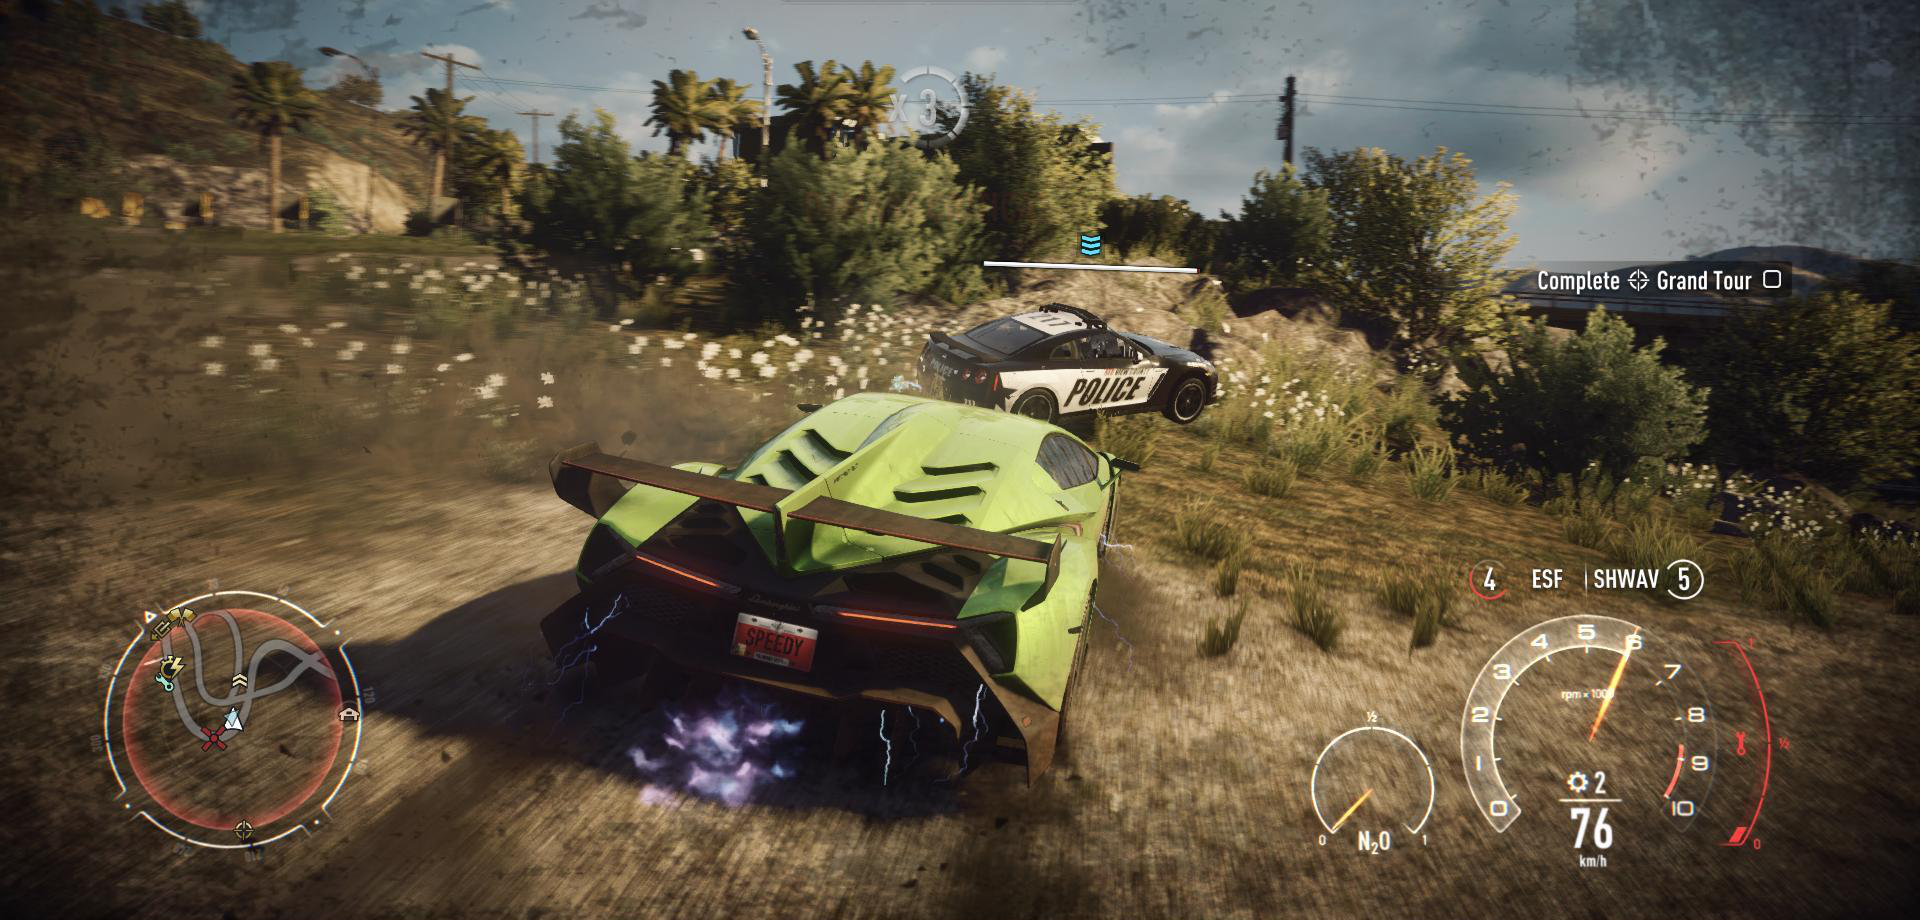

In [11]:
display(Image.open(FOLDERS['TRAIN']+"/a/716cd29c220b11ec8026842afd0f58b8.jpg",'r'))

## Let's look at the gameplay :p

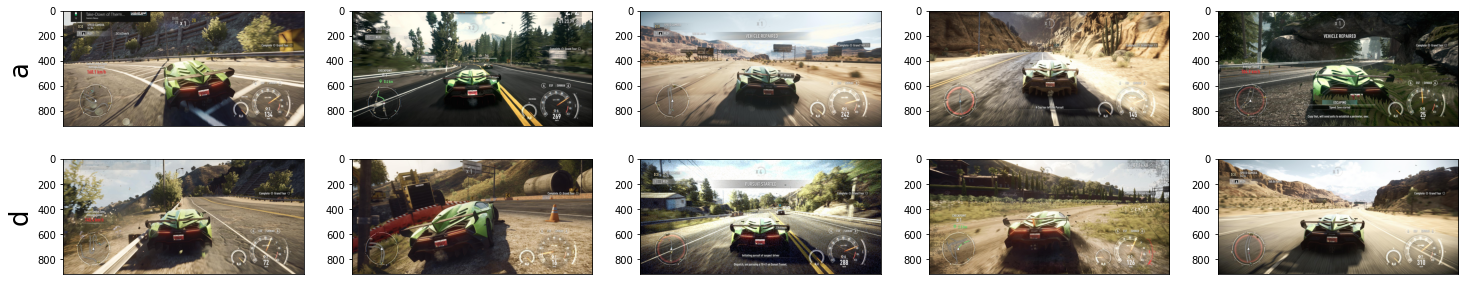

<Figure size 1152x648 with 0 Axes>

In [12]:
fig, axs = plt.subplots(2,5, figsize=(25,5), constrained_layout=False);
fig = plt.figure(figsize=(16,9));

for ax, row in zip(axs[:,0], class_list):
    ax.set_ylabel(row, rotation=90, fontsize=26)

a, b = 0, 0
for i in os.listdir(FOLDERS["TRAIN"]):
    imgs = os.listdir(os.path.join(FOLDERS["TRAIN"], i))
    random.shuffle(imgs)
    for j in imgs:
        img2 = cv2.imread(os.path.join(FOLDERS["TRAIN"], i, j))
        try:
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        except:
            continue
        rm = axs[a][b].imshow(img2)
        rm.axes.get_xaxis().set_visible(False)
        b+=1
        if b>4:
            b=0
            break
    a+=1
    if a>3:
        break

### Defining the transformations on train and test data

In [13]:
print("Defining the transformations for the speedy data")
transformations = {
    "TRAIN": transforms.Compose([
                        transforms.Resize([256,256]),
                        transforms.ColorJitter(brightness=(0.8,1.5), contrast=(0.8,1.5), saturation=(0.8,1.5)),
                        # transforms.RandomInvert(0.5),
                        # transforms.RandomRotation(degrees=(-10,10)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]),
    "TEST": transforms.Compose([
                      transforms.Resize([512,512]),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}

Defining the transformations for the speedy data


### Define dataset of the _speedata_

In [14]:
print("Creating a dataset of the speedata")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
    ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
    )
}

Creating a dataset of the speedata


### Create Dataloader of the _speedata_

In [15]:
print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        shuffle = True
    ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        shuffle = True
    )
}
print("Data preprocessing completed.")

Creating dataloaders
Data preprocessing completed.


In [27]:
torch.save(dataset, '/content/drive/MyDrive/speedata/dataset.pt')

# The G

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models.resnet import resnet18

In [17]:
# Epoch function
def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train()
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
   
  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy

  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [18]:
#@title Model Hyperparameters
EPOCH =  30#@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
# Change LR dynamically
LR = 0.01 #@param {type:"number"}

In [19]:
resnet = resnet18(pretrained=True)
resnet.eval()
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
done = False
# LRs = [0.015,0.01,0.1]
# its = [i for i in range(0,EPOCH,EPOCH//len(LRs))]

# resnet = resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features,2)
# resnet.load_state_dict(torch.load("/content/drive/MyDrive/waifus/Workspace/Models/SpeedyNet18.pth"))
# resnet = resnet.to(device)
print("RESNET18 INITIALIZED")
send().msg("RESNET18 INITIALIZED")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01)
NAME = f"SpeedyNet18"

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  messages = ''
  # if ep in its:

    # print(f"Setting LR to {LRs[its.index(ep)]}")
    # messages += f"Setting LR to {LRs[its.index(ep)]}" # for telegram

    # optimizer.param_groups[0]['lr'] = LRs[its.index(ep)]

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  messages += f"\nEpoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}" # for telegram

  vals = epoch(resnet, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Loss: {test_loss_vals[-1]:.3f} Accuracy: {test_accuracy_vals[-1]:.3f}")
  messages += f"\nLoss: {test_loss_vals[-1]:.3f} Accuracy: {test_accuracy_vals[-1]:.3f}" # for telegram
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  messages += f"\nTime elapsed: {(time.time()-start)/60:.2f} min(s)" # for telegram
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
    # if test_loss_vals[-2]>test_loss_vals[-1]:
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")
      messages += f"\nImprovement detected. Saving the model" # for telegram

      torch.save(resnet.state_dict(),model_name)
  send().msg(messages)
  send().msg('———————————————————————')

print(f"Total time taken to train for {EPOCH} epochs on ResNet18: {(time.time()-start)/60:.2f} min(s)")
send().msg(f"Total time taken to train for {EPOCH} epochs ResNet18: {(time.time()-start)/60:.2f} min(s)")
print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
send().msg(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
done = True

RESNET18 INITIALIZED
Epoch: 1/30
LR: 0.01
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/437 [00:00<?, ?it/s]

Loss: 0.694 Accuracy: 0.499
Time: 52.05 min(s)
Epoch: 2/30
LR: 0.01
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/437 [00:00<?, ?it/s]

Loss: 0.697 Accuracy: 0.499
Time: 103.82 min(s)
Epoch: 3/30
LR: 0.01
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/437 [00:00<?, ?it/s]

Loss: 0.693 Accuracy: 0.501
Time: 156.23 min(s)
Improvement detected. Saving the model

Epoch: 4/30
LR: 0.01
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/437 [00:00<?, ?it/s]

Loss: 0.693 Accuracy: 0.501
Time: 206.55 min(s)
Improvement detected. Saving the model

Epoch: 5/30
LR: 0.01
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/437 [00:00<?, ?it/s]

Loss: 0.695 Accuracy: 0.499
Time: 256.27 min(s)
Epoch: 6/30
LR: 0.01
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

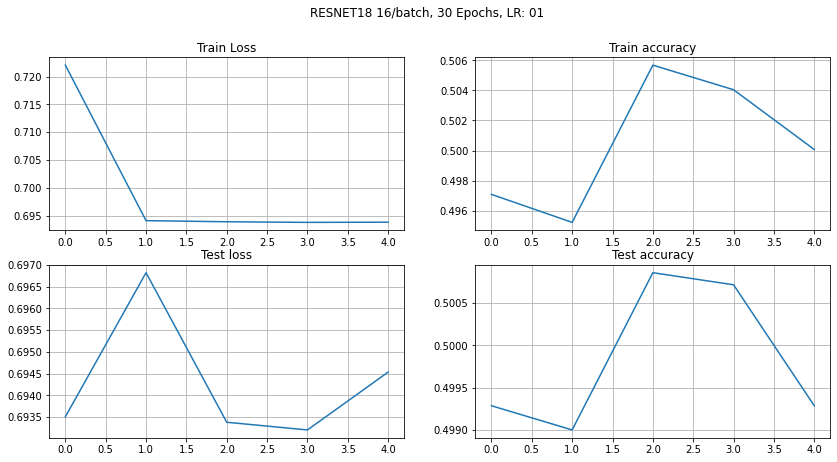

In [21]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"RESNET18 {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)
send().pic(performanceplot)